## Monitoring Results
---

In [8]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu
from smart_open import open
import pickle as pkl

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# load config and set local variables with config["mconfig"]
with open("../../config.json", "r") as f:
    config = json.load(f)
    
mconfig = config["monitoring_config"]
locals().update(mconfig)   # this would set k-v pairs in mconfig as local variables
print(mconfig.keys())

dict_keys(['mmonth', 'dev_df_path', 'monitoring_dates', 'prod_data_dates', 'data_output_path', 'artifact_path', 'date_sample_start', 'date_sample_end', 'model_paths', 'prev_test_df_path', 'modeling_df_path', 'test_df_path', 'prod_dfs_path'])


In [3]:
# artifacts path
os.makedirs(artifact_path, exist_ok=True)

test_dfs = OrderedDict()

In [4]:
# read data
df = pd.read_parquet(test_df_path)

In [5]:
models = {}
for mname, mpath in model_paths.items():
    with open(mpath, "rb") as f:
        models[mname] = pkl.load(f)

### Active Accounts

  0%|          | 0/6 [00:00<?, ?it/s]

2021-07-01 (139746, 98)
data imbalance:  37.64709051724138
2021-07-01 (139746, 98)
data imbalance:  37.64709051724138


 17%|█▋        | 1/6 [00:21<01:46, 21.27s/it]

2021-08-01 (153720, 98)
data imbalance:  35.1440329218107
2021-08-01 (153720, 98)
data imbalance:  35.1440329218107


 33%|███▎      | 2/6 [00:44<01:30, 22.51s/it]

2021-09-01 (172876, 98)
data imbalance:  34.86809197256958
2021-09-01 (172876, 98)
data imbalance:  34.86809197256958


 50%|█████     | 3/6 [01:10<01:11, 23.86s/it]

2021-10-01 (165644, 98)
data imbalance:  35.13128313891835
2021-10-01 (165644, 98)
data imbalance:  35.13128313891835


 67%|██████▋   | 4/6 [01:35<00:48, 24.50s/it]

2021-11-01 (173197, 98)
data imbalance:  42.76469135802469
2021-11-01 (173197, 98)
data imbalance:  42.76469135802469


 83%|████████▎ | 5/6 [02:01<00:25, 25.18s/it]

2021-12-01 (205763, 98)
data imbalance:  58.940991120022915
2021-12-01 (205763, 98)
data imbalance:  58.940991120022915


100%|██████████| 6/6 [02:33<00:00, 25.57s/it]


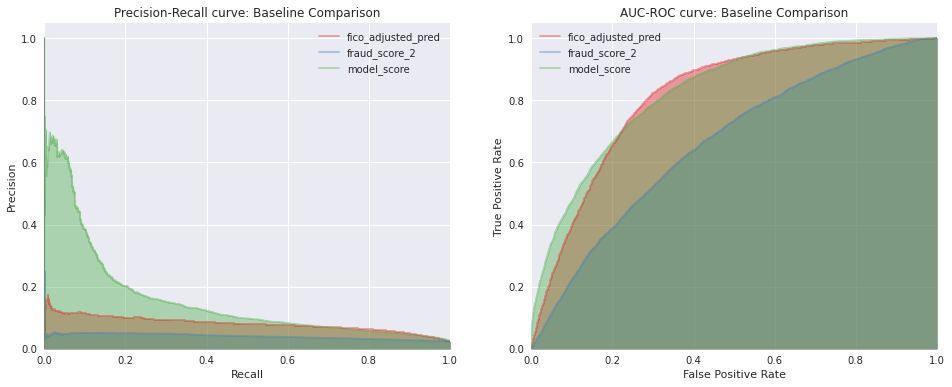

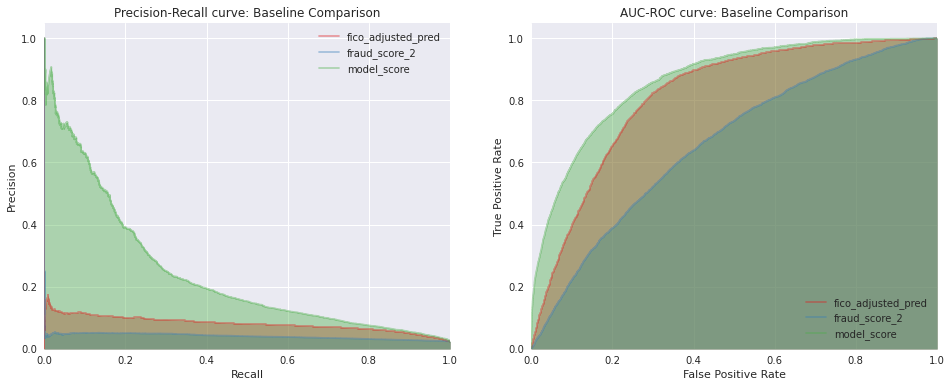

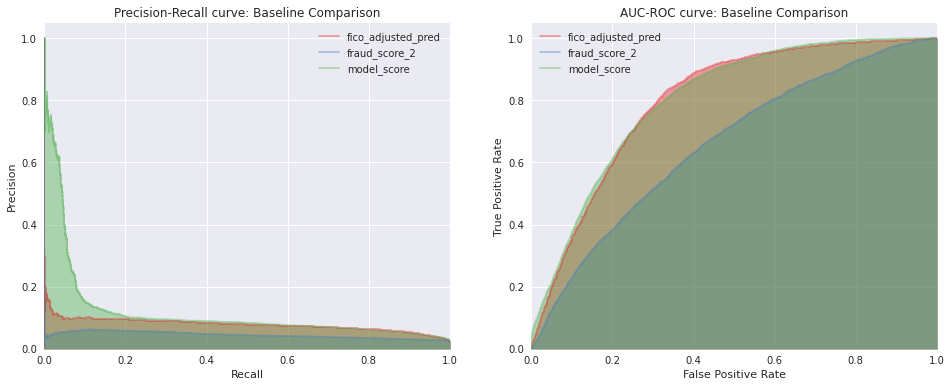

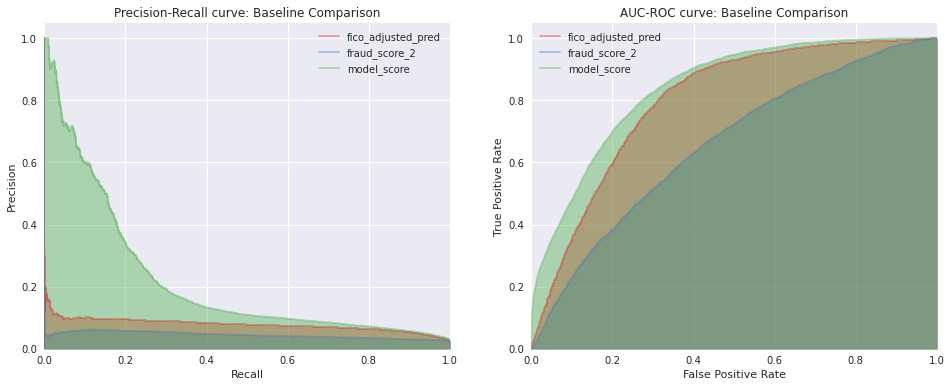

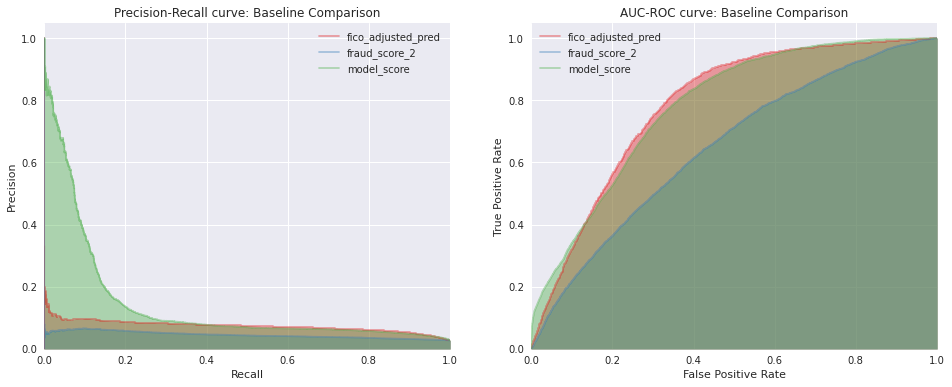

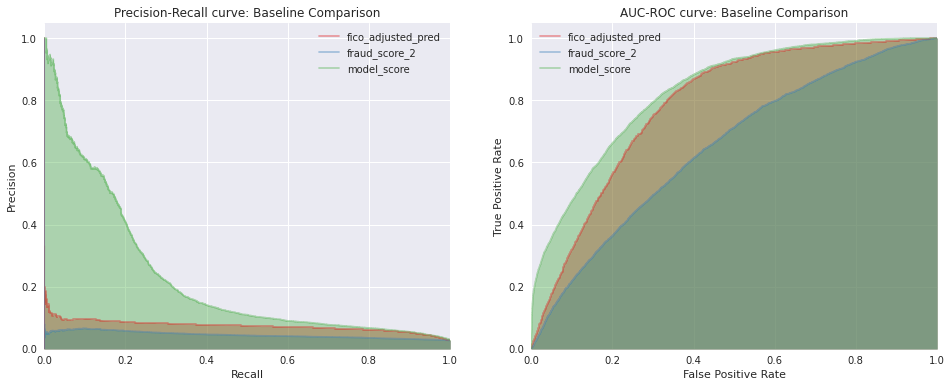

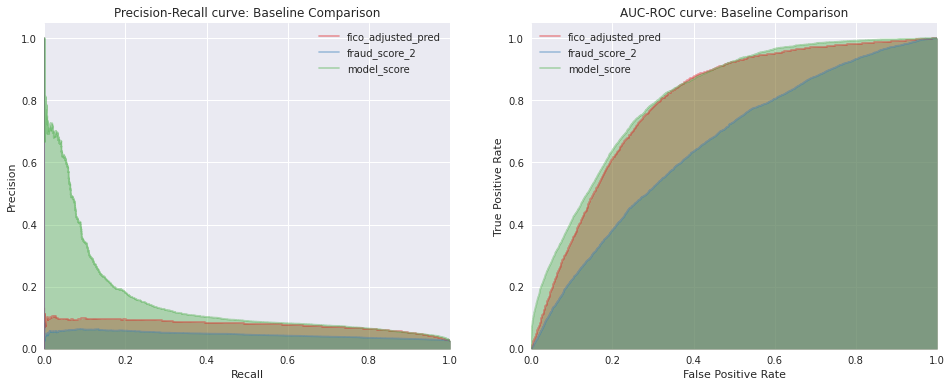

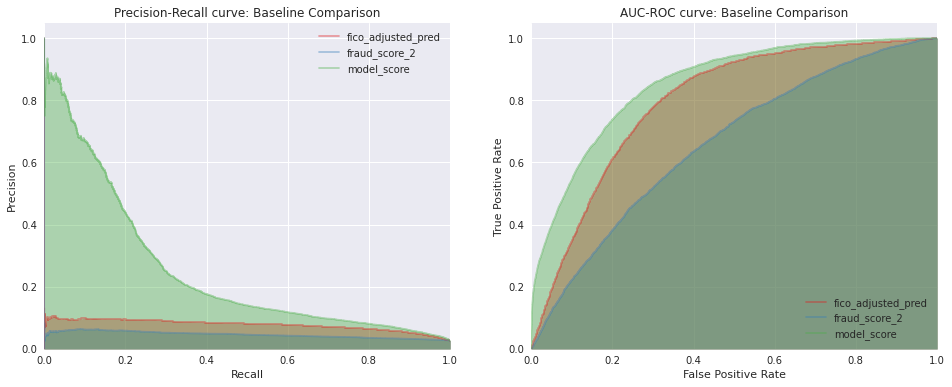

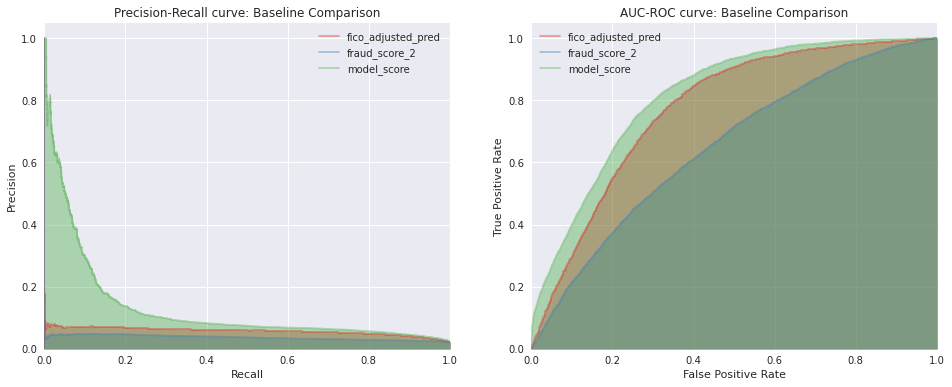

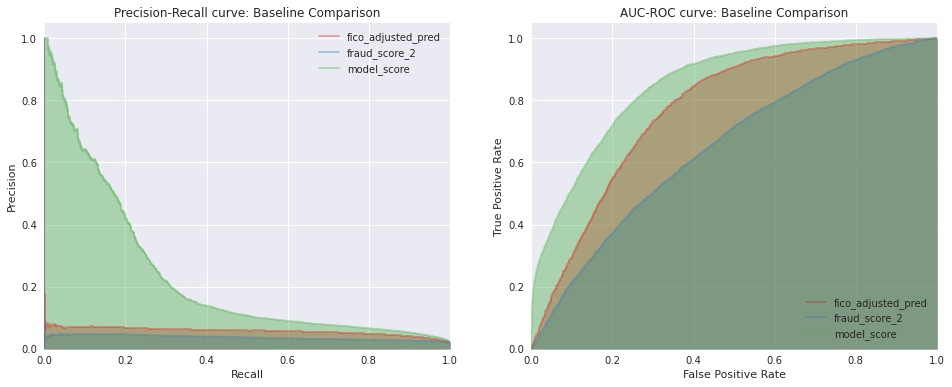

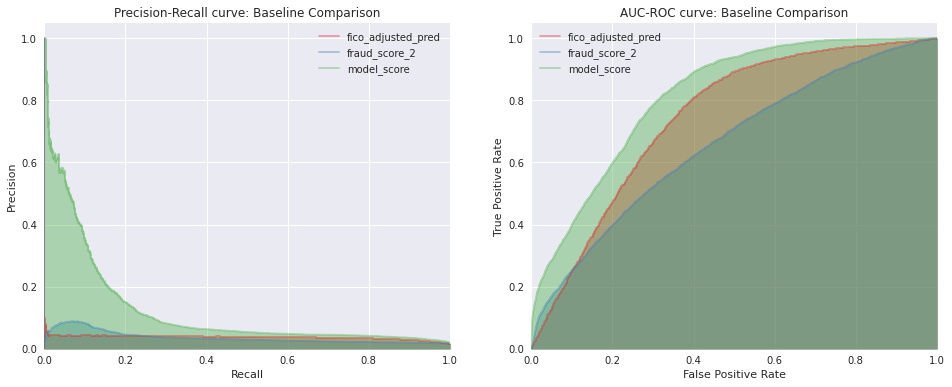

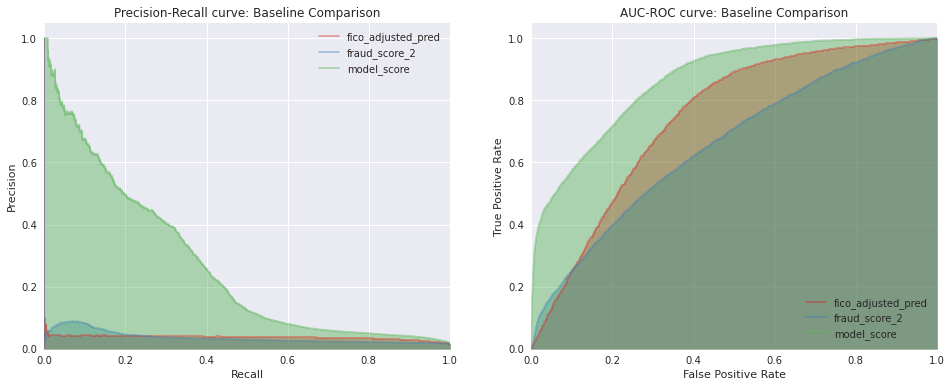

In [6]:
# get all the snapshots
for dt_str in tqdm(monitoring_dates):
    for mname, model in models.items(): 

        dt = pd.to_datetime(dt_str)

        # set folder:
        mntr_path = os.path.join(artifact_path, "monitoring", f"{mname}_{dt_str}_active")
        os.makedirs(mntr_path, exist_ok=True)
        
        # get data on that date
        df_ = df[df.is_static 
                 & (df.sample_date == dt)]
        
        # should have been processed when loaded, if not uncomment
        df_ = mu.prep_customer_data(df_)  # add is_active flag here
        df_ = df_[df_.is_active]
        print(dt_str, df_.shape)

        # see data imbalance
        print("data imbalance: ", 1/df_.target.value_counts(normalize=True).iloc[1])


        # make model pred and score
        df_["model_pred"] = model.predict_proba(df_[model.feature_name_])[:,1]
        df_["model_score"] = mu.scale_scores(df_["model_pred"])

        # insert into records
        test_dfs[dt_str] = df_
        pred_cols = ["fico_adjusted_pred", "fraud_score_2", "model_score"]
        report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)

        # store report in monitoring
        report.to_csv(os.path.join(mntr_path, f"{dt_str}_perf.csv"))

        # model prediction
        mntr.get_segmented_performances(
            {dt_str: df_},
            "target",
            ["model_score"],
            mntr_path,
            model_name="customer_risk",
        )

        # on vs fico adjusted - only valid fico
        mntr.get_model_vs_baseline(
            df_[df_.fico_score.between(300,850)],
            "target",
            "model_score",
            "fico_adjusted_pred",
            mntr_path,
        )

        # auc/pr plots - on valid fico and sigma score
        plot_df = df_  # bad style
        plot_df = plot_df[
            ~plot_df[pred_cols].isna().any(axis=1) 
            & plot_df["fico_score"].between(300, 850)
        ]
        mntr.save_valid_performance_plots(
            {dt_str: plot_df}, "target", pred_cols, mntr_path, dropna=False
        )

### Full Population
---

  0%|          | 0/6 [00:00<?, ?it/s]

2021-07-01 (965052, 91)
data imbalance:  147.2462618248398
2021-07-01 (965052, 91)
data imbalance:  147.2462618248398


 17%|█▋        | 1/6 [01:48<09:04, 108.90s/it]

2021-08-01 (1023547, 91)
data imbalance:  138.20510396975425
2021-08-01 (1023547, 91)
data imbalance:  138.20510396975425


 33%|███▎      | 2/6 [03:45<07:34, 113.61s/it]

2021-09-01 (1102748, 91)
data imbalance:  133.7312636429784
2021-09-01 (1102748, 91)
data imbalance:  133.7312636429784


 50%|█████     | 3/6 [05:51<05:57, 119.15s/it]

2021-10-01 (1171932, 91)
data imbalance:  134.72031267961833
2021-10-01 (1171932, 91)
data imbalance:  134.72031267961833


 67%|██████▋   | 4/6 [08:05<04:10, 125.19s/it]

2021-11-01 (1244022, 91)
data imbalance:  164.18397782763626
2021-11-01 (1244022, 91)
data imbalance:  164.18397782763626


 83%|████████▎ | 5/6 [10:28<02:11, 131.55s/it]

2021-12-01 (1374367, 91)
data imbalance:  206.6406555405202
2021-12-01 (1374367, 91)
data imbalance:  206.6406555405202


100%|██████████| 6/6 [13:07<00:00, 131.18s/it]


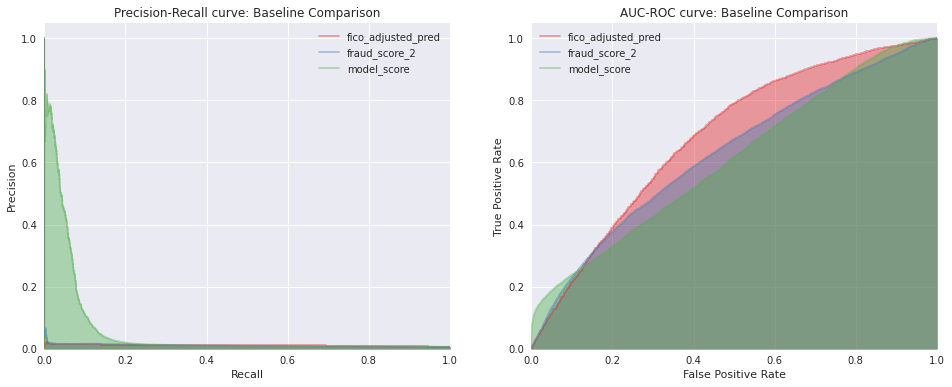

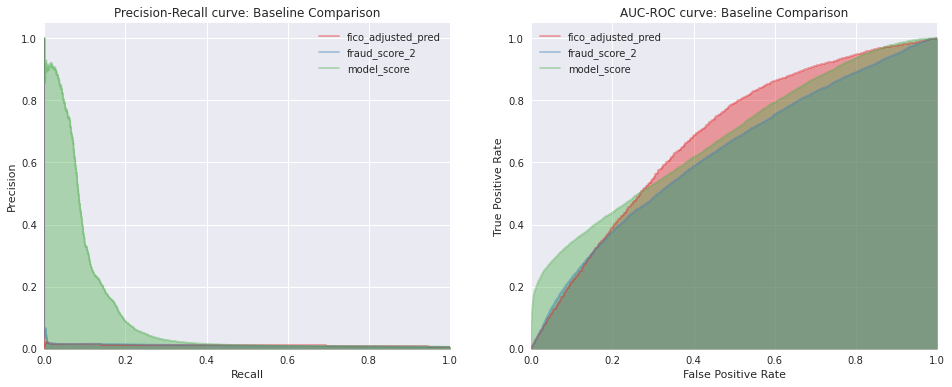

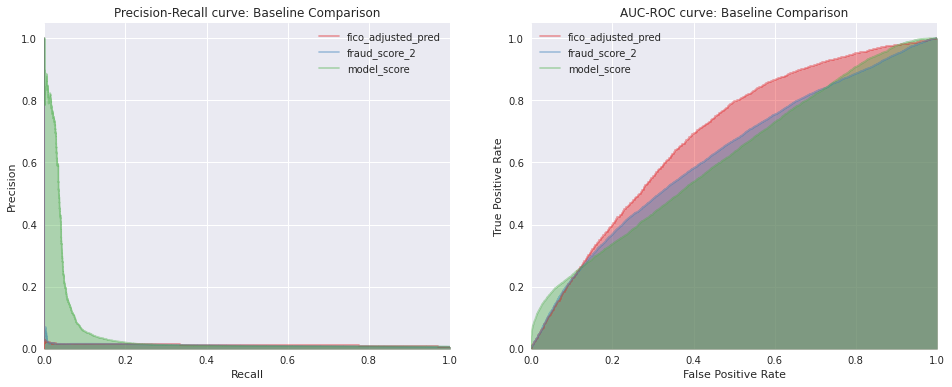

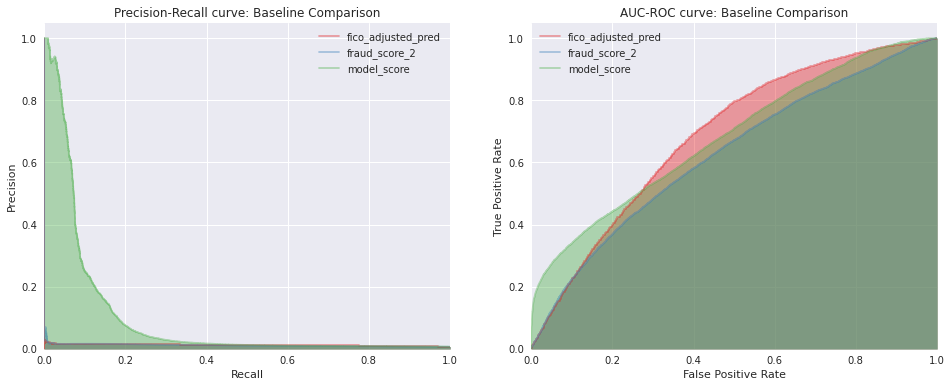

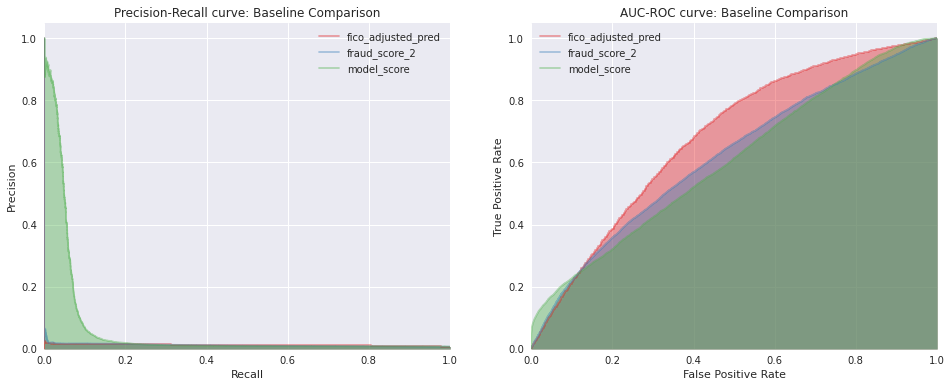

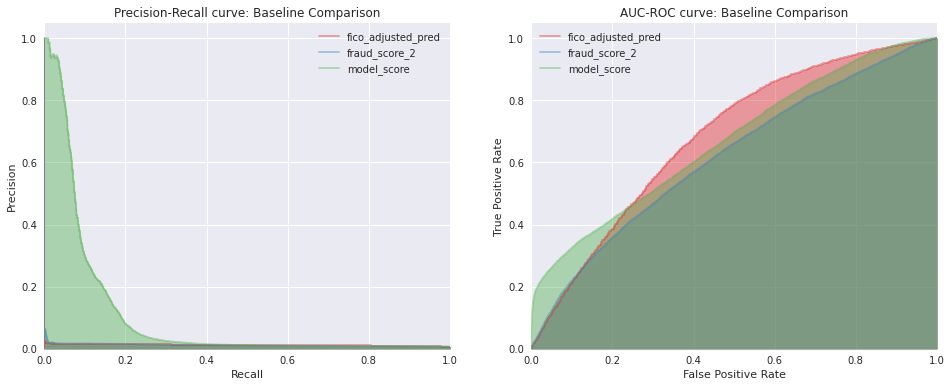

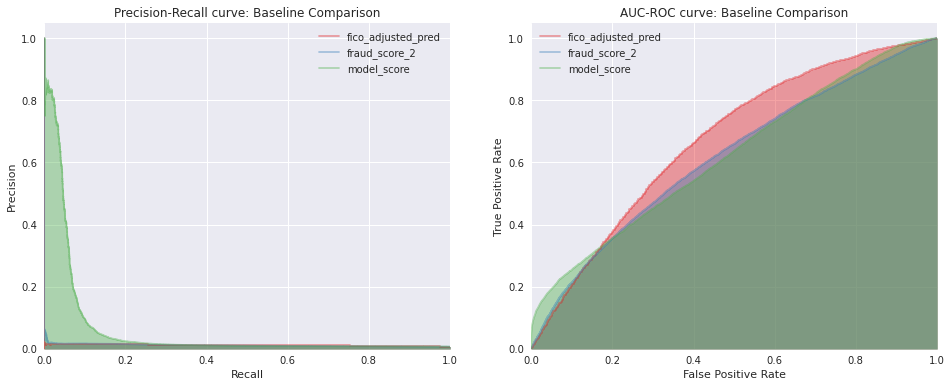

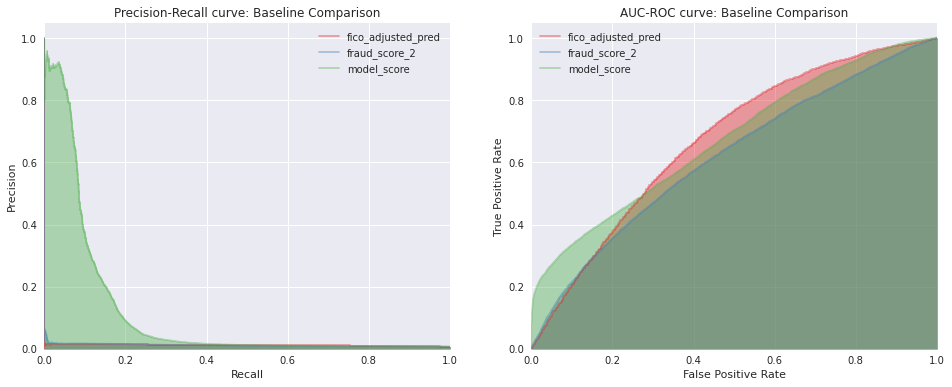

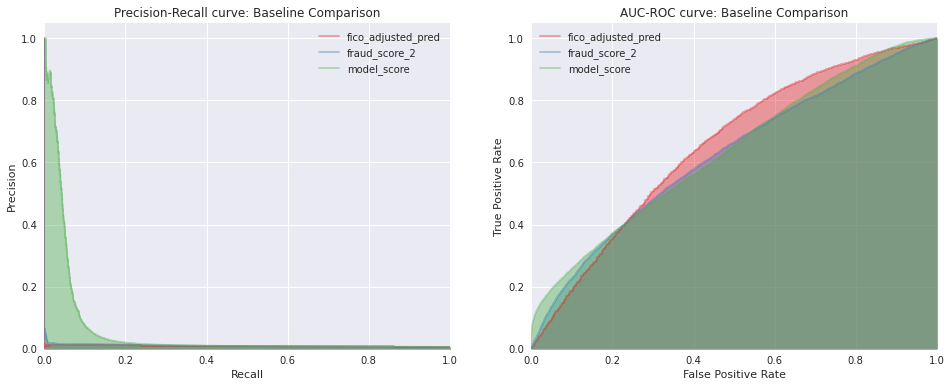

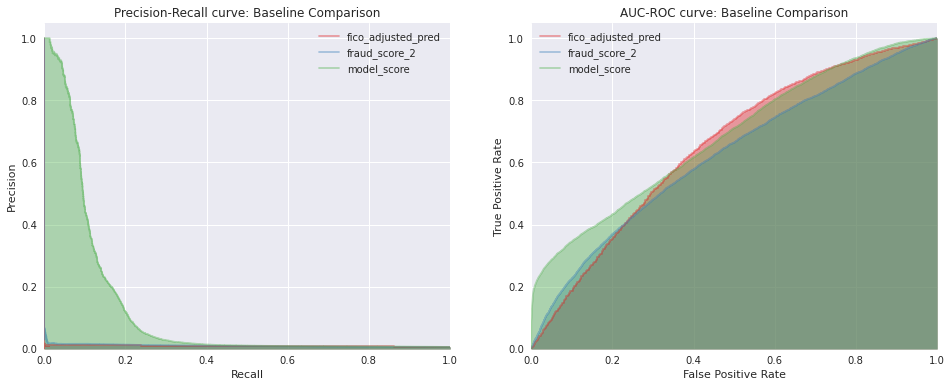

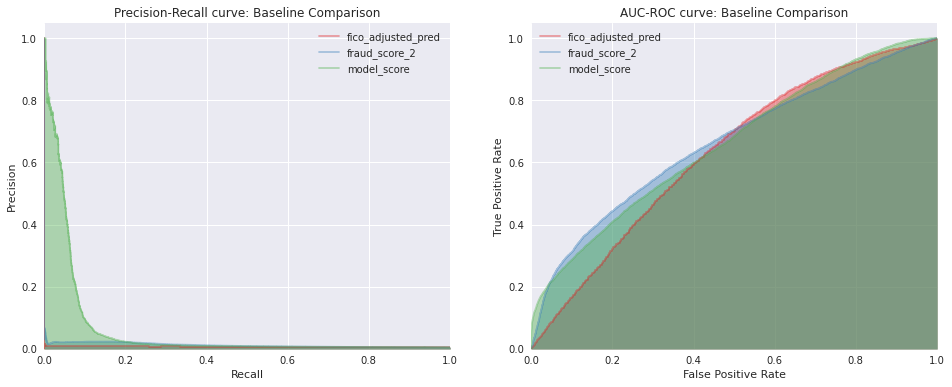

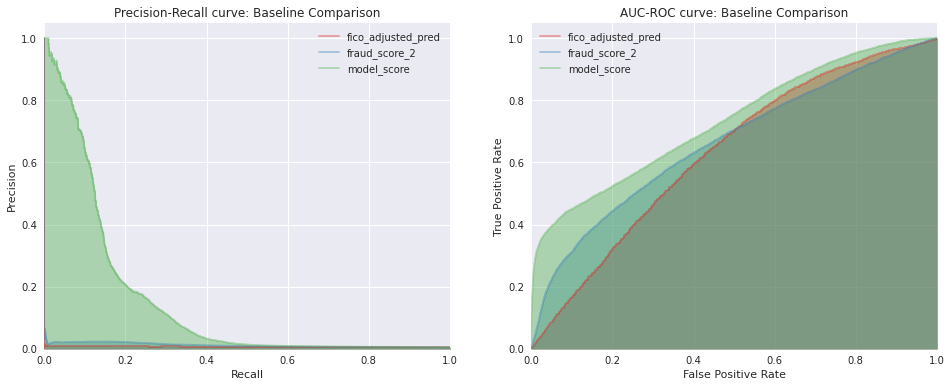

In [7]:
# get all the snapshots
for dt_str in tqdm(monitoring_dates):
    for mname, model in models.items(): 

        dt = pd.to_datetime(dt_str)

        # set folder:
        mntr_path = os.path.join(artifact_path, "monitoring", f"{mname}_{dt_str}_full")        
        os.makedirs(mntr_path, exist_ok=True)

        # get data on that date
        df_ = df[df.is_static 
                 & (df.sample_date == dt)]
        print(dt_str, df_.shape)

        # see data imbalance
        print("data imbalance: ", 1/df_.target.value_counts(normalize=True).iloc[1])

        # should have been processed when loaded, if not uncomment
        df_ = mu.prep_customer_data(df_)

        # make model pred and score
        df_["model_pred"] = model.predict_proba(df_[model.feature_name_])[:,1]
        df_["model_score"] = mu.scale_scores(df_["model_pred"])

        # insert into records
        test_dfs[dt_str] = df_
        pred_cols = ["fico_adjusted_pred", "fraud_score_2", "model_score"]
        report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)

        # store report in monitoring
        report.to_csv(os.path.join(mntr_path, f"{dt_str}_perf.csv"))

        # model prediction
        mntr.get_segmented_performances(
            {dt_str: df_},
            "target",
            ["model_score"],
            mntr_path,
            model_name="customer_risk",
        )

        # on vs fico adjusted - only valid fico
        mntr.get_model_vs_baseline(
            df_[df_.fico_score.between(300,850)],
            "target",
            "model_score",
            "fico_adjusted_pred",
            mntr_path,
        )

        # auc/pr plots - on valid fico and sigma
        plot_df = df_.copy()
        plot_df = plot_df[
            ~plot_df[pred_cols].isna().any(axis=1) 
            & plot_df["fico_score"].between(300, 850)
        ]
        mntr.save_valid_performance_plots(
            {dt_str: plot_df}, "target", pred_cols, mntr_path, dropna=False
        )